# Predicting crop yield using weather and satellite observations with DL Platform

In this tutorial, you will find corn in Iowa, calculate the vegetation indices, and calculate the weather variables necessary to develop a predictive model to find a crop yield using the Descartes Labs Platform. Some of our platform services used in this tutorial include:
* Catalog
* Metadata
* Places
* Raster
* Scenes
* Tasks

In [1]:
import descarteslabs as dl
from descarteslabs.client.services.tasks import AsyncTasks, as_completed
from descarteslabs.client.services import Catalog
from descarteslabs.client.services import Storage
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pprint import pprint
import calendar
import folium
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import pickle
import shapely
import shapely.geometry
import sklearn
import sklearn.cluster
import sklearn.ensemble
import sys

# Create storage and catalog clients
storage_client = Storage()
catalog_client = Catalog()

/opt/conda/lib/python3.7/site-packages/jinja2/runtime.py:318: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name


## Finding Corn
Use the NASS dataset for corn in Iowa counties along with Descartes Labs Places and Scenes to create a colormap of corn in Crawford County, Iowa.

In [2]:
# load yield reference data
with open('nass_county_iowa_corn_2017.json') as f:
    reference = json.load(f)

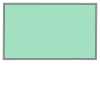

In [3]:
# find Crawford County, IA
slug = dl.places.find('iowa_west-central_crawford')[0]['slug']
county_shape = dl.places.shape(slug)
geometry = shapely.geometry.shape(county_shape['geometry'])
geometry

In [4]:
# search scenes to find imagery
scenes, geo_ctx = dl.scenes.search(
    geometry,
    products=['usda:cdl'],
    start_datetime='2017-01-01',
    end_datetime='2018-01-01',
    limit=500
)
scenes, geo_ctx

(SceneCollection of 1 scene
   * Dates: Dec 31, 2017 to Dec 31, 2017
   * Products: usda:cdl: 1, AOI(geometry=<shapely.geom...x7f66b686b710>,
     resolution=30,
     crs='+proj=aea +l...s=m +no_defs ',
     align_pixels=True,
     bounds=(-95.672771, 41.863147, -95.090851, 42.211408),
     bounds_crs='EPSG:4326',
     shape=None))

In [5]:
# rasterize all contained scenes into an ndarray using the geo context.
arr = scenes.mosaic("class", geo_ctx, mask_alpha=False)
arr.shape # one band, 1310 pixels tall by 1587 pixels wide

(1, 1310, 1587)

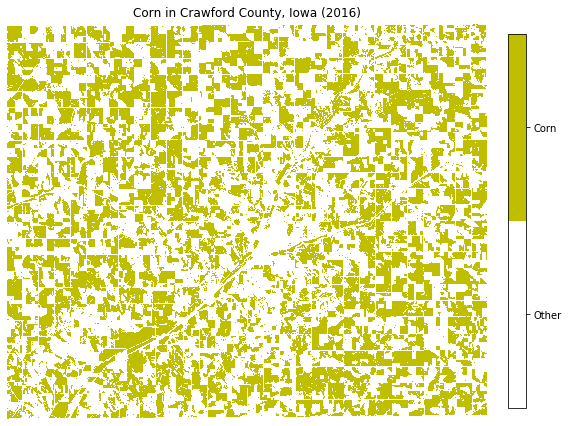

In [6]:
# filter the ndarray to just corn
corn = np.where(arr == 1, 1, 0)[0,:,:]

# create the colormap
colorlist = ['w', 'y']
cmap = colors.ListedColormap(colorlist)
bounds = [0, 1, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

# plot the map
fig, ax = plt.subplots(figsize=(8, 8))
cax = plt.imshow(corn, cmap=cmap, norm=norm)
plt.title('Corn in Crawford County, Iowa (2016)')
cbar = fig.colorbar(cax, ticks=[0.5, 1.5], orientation='vertical', fraction=0.036, pad=0.04)
cbar.ax.set_yticklabels(['Other', 'Corn']) 
plt.axis('off')
plt.tight_layout()

## Calculate vegetation indices
To calculate vegetation indices, you will use Scenes to search for NDVI imagery, rasterize the contained scenes into an ndarray, and then plot the results against our colormap.

In [7]:
# search for NDVI scenes
# note: we pass in geo_ctx instead of AOI to ensure returned scenes are in the correct coordinate reference system
scenes, geo_ctx = dl.scenes.search(
    geo_ctx,
    products=['8291fd932b469d8d81701dd6079d64b0fabc5f93:moody:l8_2017_veg_healthmax:v1'],
    start_datetime='2017-01-01',
    end_datetime='2017-12-31',
    limit=500
)
scenes

SceneCollection of 6 scenes
  * Dates: Jul 01, 2017 to Jul 01, 2017
  * Products: 8291fd932b469d8d81701dd6079d64b0fabc5f93:moody:l8_2017_veg_healthmax:v1: 6

In [8]:
# rasterize all contained scenes into an ndarray using the geo context.
arr = scenes.mosaic('veg_healthmax', geo_ctx, mask_alpha=False)[0, :, :]
arr.shape #same shape as previous steps

(1310, 1587)

In [9]:
# filter the ndarray to just corn
corn_ndvi = np.where(corn == 1, arr, 0)

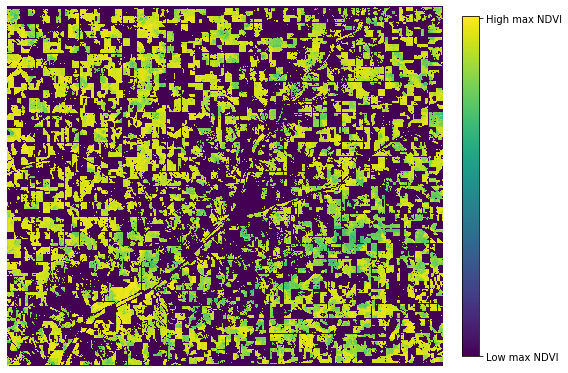

In [10]:
# plot the results against our colormap
fig, ax = plt.subplots(figsize=(8, 8))
cax = plt.imshow(corn_ndvi)
cbar = fig.colorbar(
    cax,
    ticks=[0, 240],
    orientation='vertical',
    fraction=0.036,
    pad=0.04
)
cbar.ax.set_yticklabels(['Low max NDVI', 'High max NDVI'])
plt.axis('off')
plt.tight_layout()

## Calculate weather variables
To calculate the weather variables, you will use Raster to create a global tiling across our area of interest, use Catalog to create a product in your Descartes Labs user namespace, retrieve a stack of images using Scenes and their IDs using Metadata, and finally use Raster to create a stack of DLTiles. 

Once you have the tiles, you will use the Tasks service to create a task to predict water over the DLTiles and then test the function. After the function has been tested, you will use Tasks to run the job that will predict water.

In [11]:
# create a global tiling across our AOI
shape = dl.places.shape('north-america_united-states_iowa')
resolution = 30
tile_dimension = 2048
pad = 0

tiles = dl.raster.dltiles_from_shape(
    resolution=resolution, 
    tilesize=tile_dimension, 
    pad=pad, 
    shape=shape
)

print('Number of tiles = {}'.format(len(tiles['features'])))

Number of tiles = 58


In [12]:
# create a product in your Descartes Labs user namespace
from descarteslabs.client.services.catalog import Catalog
auth = dl.Auth()

# get Descartes Labs username
user = auth.payload['name']

# generate product ID from username
product_id = '{}:{}:demo:crop:iowa'.format(
    auth.namespace,
    user.lower().replace(' ', '')
) 

product_title = '{} Growing Degree Days'.format(user) 

print(f"""
The next cells will create the following product:
    title: {product_title}
    id:    {product_id}
""")


The next cells will create the following product:
    title: Samantha Andrews Growing Degree Days
    id:    12e7709685ba686556ce8f4fd779d73c6f610d2b:samanthaandrews:demo:crop:iowa



In [13]:
# check if product already exists, remove if it does
already_exists = list(filter(lambda p: p.get('id') == product_id, dl.Catalog().own_products()))
if already_exists:
    print("Product already exists, removing existing one...")
    dl.Catalog().remove_product(product_id, cascade=True)
    print("...done")

# add product to your user namespace
product = dl.Catalog().add_product(
    product_id,
    title=product_title,
    description="GDD calculated from GSOD for crop demo"
)['data']['id']
print(product)

# add bands
band_id = dl.Catalog().add_band(
    product_id,
    'gdd',
    jpx_layer=0,
    srcfile=0,
    srcband=1,  
    nbits=16,
    dtype='Int16',
    nodata=0,
    data_range=[0, 2**16 - 1],
    type='spectral',
    default_range=(0, 5500),
    data_unit_description='0.01 celsius',
    colormap_name='viridis'
)['data']['id']
print(band_id)

print("Done! View your product here: https://catalog.descarteslabs.com/?/product/{}".format(product_id))

Product already exists, removing existing one...
...done
12e7709685ba686556ce8f4fd779d73c6f610d2b:samanthaandrews:demo:crop:iowa


/opt/conda/lib/python3.7/site-packages/descarteslabs/client/deprecation.py:45: DeprecationWarning: The parameter `nbits` has been deprecated and will be removed in future versions.
  warnings.warn(msg, DeprecationWarning)


12e7709685ba686556ce8f4fd779d73c6f610d2b:samanthaandrews:demo:crop:iowa:gdd
Done! View your product here: https://catalog.descarteslabs.com/?/product/12e7709685ba686556ce8f4fd779d73c6f610d2b:samanthaandrews:demo:crop:iowa


In [14]:
tile = tiles['features'][0]
start_date = '2017-05-01'
end_date = '2017-10-15'
product = 'fcd57a7bf668c5b65d49c5e32130a2c0a5281322:daily:gsod:interp:dev-v0'
bands = ['tavg']

# search scenes to find imagery related to our tile geo context
tile_geo_ctx = dl.scenes.DLTile.from_key(tile.properties.key)
scenes, geo_ctx = dl.scenes.search(
    tile_geo_ctx,
    products=[product],
    start_datetime=start_date,
    end_datetime=end_date
)

# load scenes into a 4D ndarray
new_image_stack, new_meta = scenes.stack(
    bands,
    tile_geo_ctx,
    raster_info=True,
    mask_alpha=False,
    bands_axis=-1
)

# search metadata related to our tile geometry to get our image IDs
available_scenes = dl.metadata.search(
    products=[product],
    geom=tile['geometry'],
    start_datetime=start_date,
    end_datetime=end_date
)

# scene IDs
ids = [scene['id'] for scene in available_scenes['features']]

# retrieve our stack of rasters as a 4D ndarray
old_image_stack, old_meta = dl.raster.stack(
    ids,
    bands=bands,
    dltile=tile,
    cutline=shape,
    data_type='Int32'
)

In [15]:
# sort our new and old image stacks by date
old_dates = [a.properties.acquired for a in available_scenes.features]
new_dates = [a.properties.acquired for a in scenes]

old_dates.sort()
new_dates.sort()

In [16]:
# identify if any dates do not match
for o, n in zip(old_dates, new_dates):
    if o != n:
        print(f"These don't match: {o} ... {n}")

In [17]:
# remove duplicated values
old = np.unique(old_image_stack)
new = np.unique(new_image_stack)

print(old.dtype, new.dtype)
print(len(old), len(new))

int32 int16
190 1891


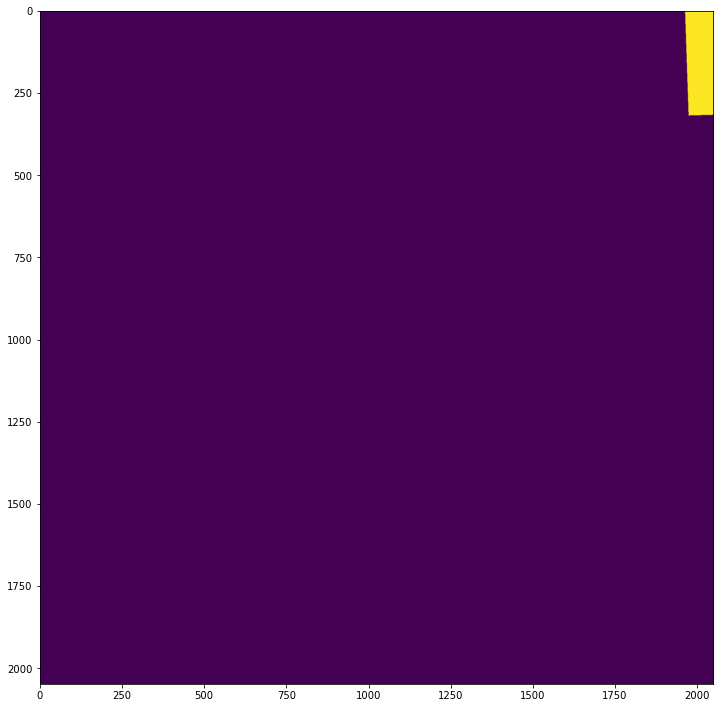

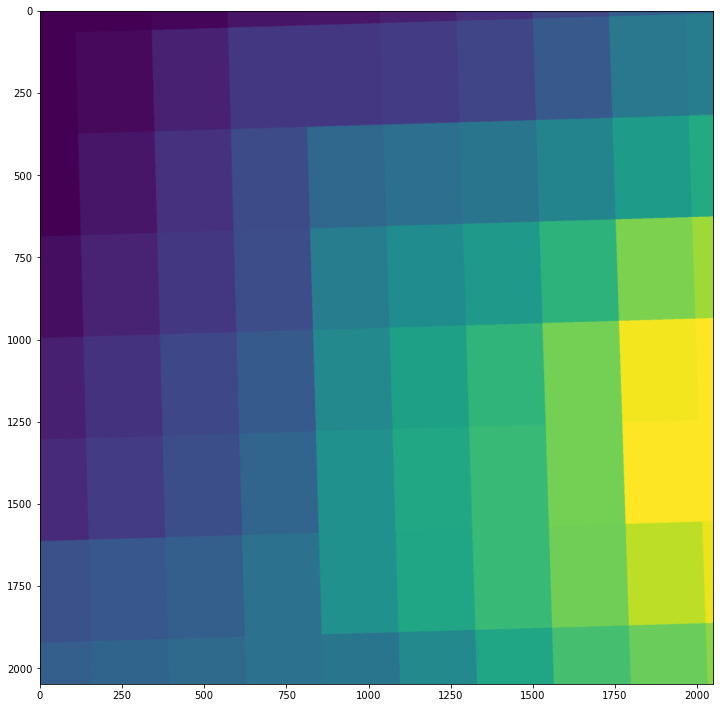

In [18]:
dl.scenes.display(old_image_stack[-1], bands_axis=-1, colormap='viridis')
dl.scenes.display(new_image_stack[-1], bands_axis=-1, colormap='viridis')

In [19]:
# create the function that creates the task to predict water over a DLTile
def calculate_gdd_task(tile, shape, start_date, end_date, input_product, output_product):
    """ predict water over dltile with Tasks """
    
    import descarteslabs as dl
    from descarteslabs.client.services.catalog import Catalog
    from descarteslabs.client.services.storage import Storage
    
    storage_client = Storage()
    catalog = Catalog()
    
    import os
    import numpy as np
    import pickle


    def search_and_raster(product, tile, shape, start_date, end_date):
    
        scenes, geo_ctx = dl.scenes.search(
            tile['geometry'],
            products=[product],
            start_datetime=start_date,
            end_datetime=end_date
        )

        tile_geo_ctx = dl.scenes.DLTile.from_key(tile['properties']['key'])

        image_stack, meta = scenes.stack(
            ['tavg'],
            tile_geo_ctx,
            raster_info=True,
            mask_alpha=False,
            bands_axis=-1
        )

        print(image_stack.shape) # expecting (100, 2048, 2048, 1)
        dl.scenes.display(image_stack[0], bands_axis=-1)

        uniques = np.unique(image_stack[0])
        print(f"first layer has {uniques} unique values")

        return image_stack[:, :, :, 0], meta[0]


    def calc_gdd(image_stack):
        ''' calculate gdd for each pixel'''

        gdd = image_stack - 1000
        gdd = np.where(gdd < 0, 0, gdd)
        
        # calculate cumulative GDD 
        # scale to fit in uint16
        cum_gdd = cum_gdd = np.ndarray.astype((np.sum(gdd, axis=0) / 100), 'uint16')
        
        return cum_gdd
    
    ''' predict water over each compositing period '''
    outdir = os.path.join(os.path.expanduser('~'), 'temp')
    if not os.path.isdir(outdir):
            os.makedirs(outdir)

    key = tile['properties']['key']
    outfile = 'gdd_{}_{}_{}.tif'.format(key, start_date, end_date)

    # get imagery and stats for each product
    image_stack, meta = search_and_raster(input_product, tile, shape, start_date, end_date)
    stats = calc_gdd(image_stack)
    
    # save to product to Catalog    
    upload_id = catalog.upload_ndarray(
        stats,
        output_product,
        outfile,
        raster_meta=meta
    )
        
    return "Processed dltile {}\nupload_id {}".format(key, upload_id)

(100, 2048, 2048, 1)


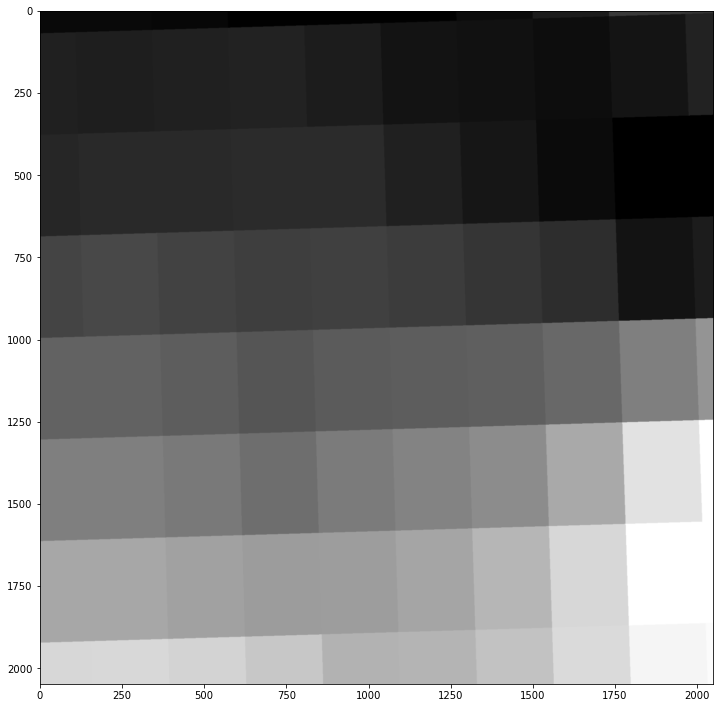

first layer has [462 469 470 473 474 475 476 478 479 480 481 484 485 486 487 489 491 492
 493 497 499 501 502 503 504 505 507 514 517 518 519 521 524 527 533 534
 536 538 543 547 551 552 554 556 557 558 563 564 565 571 574 580 582 583
 584 588 598 601 603 611 624] unique values


'Processed dltile 2048:0:30.0:14:3:74\nupload_id gdd_2048:0:30.0:14:3:74_2017-05-01_2017-10-15.tif'

In [20]:
# test the task function
calculate_gdd_task(
    tiles['features'][0],
    shape,
    '2017-05-01',
    '2017-10-15',
    'fcd57a7bf668c5b65d49c5e32130a2c0a5281322:daily:gsod:interp:dev-v0',
    product_id
)

In [21]:
# run the tasks to predict water

from descarteslabs.client.services.tasks import AsyncTasks, as_completed
at = AsyncTasks()

# get the correct python version to match the image
version = "{}.{}".format(sys.version_info[0], sys.version_info[1])
image_link='us.gcr.io/dl-ci-cd/images/tasks/public/py{}/default:v2019.02.12'.format(version)

async_function = at.create_function(calculate_gdd_task, 
                                    name="demo-crop-yield",
                                    memory='10Gi',
                                    image=image_link,
                                    task_timeout=5000
                                    )

In [22]:
# submit the tasks

input_product = 'fcd57a7bf668c5b65d49c5e32130a2c0a5281322:daily:gsod:interp:dev-v0'

tasks = [async_function(tile, shape, '2017-05-01', '2017-10-15', input_product, product_id) 
         for tile in tiles['features']]


## Monitor the tail generation tasks

In [23]:
from IPython.display import IFrame
IFrame('https://monitor.descarteslabs.com', width="100%", height="600px")

In [66]:
# Data are now available through the programmatic API

available_scenes = dl.metadata.search(products=[product_id])

print(len(available_scenes['features']))

0


## Develop a predictive model
### Train a model

In [67]:
from sklearn.tree import DecisionTreeRegressor

features = []
values = []
for slug in sorted(reference.keys()):
    features.append(reference[slug]['gdd'] + reference[slug]['ndvi'])
    values.append(reference[slug]['yld'])
    
regr = DecisionTreeRegressor(max_depth=7)
regr.fit(features, values)
print('r2 = {}'.format(regr.score(features, values)))

r2 = 0.921710950264327


### Predict yield over Illinois

In [68]:
with open('nass_county_illinois_corn_2017_predictor.json') as f:
    predict_data = json.load(f)

features = []
values = []
geometries = []
for slug in sorted(predict_data.keys()):
    features.append(list(predict_data[slug]['gdd']) + list(predict_data[slug]['ndvi']))
    values.append(predict_data[slug]['yld'])
    geometries.append({'properties': {'name': slug},
                       'geometry': predict_data[slug]['geometry'],
                       'type': 'Feature'})
    
yield_predictions = regr.predict(np.array(features))

### Plot the predictions

In [69]:
df = pandas.DataFrame.from_dict({'yield': yield_predictions, 'name': sorted(predict_data.keys())})
counties = {'type': 'FeatureCollection', 'features': geometries}

m = folium.Map(location=[40.0468423, -89.1366099], zoom_start=6)
m.choropleth(geo_data=counties, 
           data=df,
           columns=['name', 'yield'],
           key_on='feature.properties.name',
           fill_color='YlGn',
           fill_opacity=1,
           legend_name='Predicted Corn Yield - 2017 (bu/acre)')
m

/opt/conda/lib/python3.6/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/opt/conda/lib/python3.6/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/opt/conda/lib/python3.6/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/opt/conda/lib/python3.6/site-packages/pkg_resources/__init__.p